# Whiteaway case opgave Juni 2021

Data:

* https://www.kaggle.com/carrie1/ecommerce-data




## Overview

1. Begrænsninger ved dette datasæt.

2. Basic stats og exploration.

3. Recommendation systems:

     1. Non-personalized input: Product page view, eller Indkøbskurv.
     2. Personalized input: User purchase history.

3. Primitiv produkt-popularitets anbefalings model.

4. Graf-baserede modeller (produkt-orienteret; for et enkelt produkt, eller en indkøbskurv med flere produkter).

     1. Model baseret på "hvad blev købt sammen" (i samme ordre).
     2. Model baseret på "kunder som tidligere har købt X er mere tilbøjelige til at købe Y".

5. Personaliseret model, baseret på hvad lignende kunder tidligere har købt.

     1. Her går vi ind og ser på hvilke andre kunder en kunde ligner, og anbefaler ud fra det.

6. Anden-ordens effekter:

     1. Negativ respons

7. Standard Recommendation systemer:

     1. Collaborative filtering.
     2. Content-based recommendations.

8. Efterbehandling af anbefalinger

     1. Hvis en kunde fx allerede har købt en støvsuger, så køber han nok ikke en mere.

8. Evaluering og kvantificering af modeller.

     1. Evaluering baseret på opdeling af eksisterende salgs datasæt i to dele. Første bruges til at lave model, anden del til at evaluere. *Dette er ikke optimalt,* men det bedste vi kan gøre med bare ét statisk datasæt.

9. Fuldt system: Kombinering af anbefalinger fra forskellige recommenders

    1. Vi har mulighed for at lave mange forskellige recommender systemer. 
       Hvordan kombinerer vi dem bedst, så vi får et optimalt output?

10. Diskussion



## Begrænsninger ved dette datasæt

(Og modeller baseret primært på dette dataset)

***Retrospektivt:***

* Beskriver hvilke produkter kunder har købt sammen.
* Hvis kunde A har købt produkt X, hvilke produkter har kunde A købt sammen med X eller efterfølgende?

* Reflekterer hvilke påvirkninger kunderne tidligere har været udsat for -> Bias.

* Vi er ofte mere interesseret i: Hvis kunde A lægger produkt X i sin indkøbsvogn, hvilke produktanbefalinger resulterer så i mest mersalg?

* Fx: Kunder der har købt en Dyson støvsuger har også købt Dyson-branded tilbehør.
* Resultat: Den retrospektive model fremhæver produktanbefalinger for Dyson-branded tilbehør.


***Positivt feedback loop***:

* Kunde A har købt/kurvet produkt X.
  * -> Model anbefaler produkt Y til kunde A
  * -> Kunde A køber produkt Y
  * -> Modellen forstærkes i at anbefale produkt Y til kunder som har købt/kurvet produkt X. 

* Det er vigtigt at måle *effekten* af produktanbefalinger:
* *Hvis* kunde A vises en produktanbefaling for produkt Y, hvor sandsynligt er det så at kunde A køber produkt Y


**Fokus på salg af *tilbehør*:**

* Kunder som køber en Dyson støvsuger er tilbøjelige til at købe tilbehør til støvsugeren sammen eller efterfølgende. Så den retrospektive model anbefaler Dyson-tilbehør til kunden (og det er fint - bekvemt for kunden).

* Men det er også vigtigt at have en anden model som kan anbefale mere end bare tilbehør.
* Kan til dels afhjælpes ved at inkludere produktpriser, men det kan marginalisere billigt tilbehør som ellers ville øge kundetilfredsheden -> vigtigt at have begge typer anbefalinger.

* Hvis vi fx anbefaler en robotstøvsuger, så er det måske ikke helt så effektivt "per anbefaling", men i de tilfælde hvor det virker, så ender vi med betydeligt mere mersalg i forhold til bare at anbefale tilbehør, som kunden måske allerede havde besluttet sig for at købe.


**Ikke nogen *produktkategorier*:**

* Datasættet har ikke nogen "kategorier", som ellers vil gøre det nemmere at filtrere.
* Fx, hvis modellen anbefaler en kunde at købe produkt Y, men kunden tidligere har købt et tilsvarende produkt til Y men fx et andet mærke eller model, så vil kunden   
* Det bliver med tiden reflekteret i modellen (negative inputs), men det tager lang tid hvis modellen skal finde det negative input for hvert tilsvarende produkt i samme kategori. Det er hurtigere hvis modellen kan sige "kunde A har allerede købt en blender, så lad være med at anbefale nogen blendere overhovedet (men du kan stadig anbefale *tilbehør* til den blender han har købt)." 


***Konservativt:***

* Tager lang tid om at ændre sig, fordi den er baseret på historiske salg.
* Kan afhjælpes ved at have modeller som kigger på kortere tid (seneste uge/måned) -> men det giver mindre datagrundlag så større usikkerhed.
* Igen, det er bedre med modeller, som måler **effekten** af konkrete produktanbefalinger til en given type kunde.


Det leder mig til en anden begrænsning ved dette dataset: 



## Yderligere data ønsket

Indsamling af data (for hver kunde session) udover kun selve *salget*:

* Sidevisninger.
* Navigation.
* Søgninger.
* Referencer fra mails og eksterne sider.
* Produktanbefalinger. Hvilke produkter får kunden anbefalet.
* Manuelle produktanbefalinger/reklamer vs automatiske.
* Indkøbskurv (tilføjelser, fjernelser).




## Disclaimer:

Jeg har selv lavet det meste af dette arbejde "fra grunden".

Normalt vil jeg starte med at kigge på eksisterende pakker og litteratur når jeg skal løse et problem, og modificere og bygge op fra det, og først til sidst starte "from scratch" med mine egne idéer.



In [1]:
import pandas as pd

from collections import defaultdict
import timeit
import itertools
import random
import matplotlib
from matplotlib import pyplot
from pprint import pprint

In [2]:
# Notebook configuratio: Automatic display of plots, etc


In [3]:
# Download data:
# Requires kaggle login
# Download manually from https://www.kaggle.com/carrie1/ecommerce-data

# Download with Kaggle API and python package
# Auth in environment vars:
#   export KAGGLE_USERNAME=datadinosaur
#   export KAGGLE_KEY=xxxxxxxxxxxxxx
# Auth in kaggle.json file: 
# Download kaggle.json from account page on kaggle.com and place in ~/.kaggle/kaggle.json
# pip install kaggle

# import kaggle
# kaggle.api.authenticate()
# kaggle.api.dataset_download_files(
#     'The_name_of_the_dataset', 
#     path='data/raw', 
#     unzip=True
# )

In [4]:
# Load data
df = df_raw = pd.read_csv("../data/raw/data.csv", keep_default_na=False)
print(f"Table rows:", len(df))
df.head()

Table rows: 541909


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [5]:
# Remove bad data:
df = df_raw
print("Rows before QA filtering:", len(df))

# Remove lines with N/A values:
for column in df.columns:
    print(f" - NaN {column}:", df[column].isna().sum()) 
df = df_dropna = df.dropna()
print("Rows after dropping N/A:", len(df))

print("Columns with empty values:")
for column in df.columns:
    print(f" - {column} empty values:", (df[column] == '').sum()) 
    df = df[~(df[column] == '')]
print("Rows after dropping rows with empty values:", len(df))

# Remove lines that does not represent an actual product:
print("Non-product stock codes:")
non_product_stock_codes = ['BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST']
for code in non_product_stock_codes:
    print(f" - {code} lines:", (df['StockCode'] == code).sum()) 
df = df[~df['StockCode'].isin(['BANK CHARGES', 'C2', 'CRUK', 'D', 'DOT', 'M', 'PADS', 'POST'])]
print("Rows after dropping non-product lines:", len(df))

print("Rows after QA filtering:", len(df))


Rows before QA filtering: 541909
 - NaN InvoiceNo: 0
 - NaN StockCode: 0
 - NaN Description: 0
 - NaN Quantity: 0
 - NaN InvoiceDate: 0
 - NaN UnitPrice: 0
 - NaN CustomerID: 0
 - NaN Country: 0
Rows after dropping N/A: 541909
Columns with empty values:
 - InvoiceNo empty values: 0
 - StockCode empty values: 0
 - Description empty values: 1454
 - Quantity empty values: 0
 - InvoiceDate empty values: 0
 - UnitPrice empty values: 0
 - CustomerID empty values: 133626
 - Country empty values: 0
Rows after dropping rows with empty values: 406829
Non-product stock codes:
 - BANK CHARGES lines: 12
 - C2 lines: 134
 - CRUK lines: 16
 - D lines: 77
 - DOT lines: 16
 - M lines: 465
 - PADS lines: 4
 - POST lines: 1196
Rows after dropping non-product lines: 404909
Rows after QA filtering: 404909


In [6]:
# Reduce table size for dev/testing:
# df_fullsize = df
# df = df[:20000]
# print("Rows after reducing table size for testing:", len(df))

## Basic stats:

Histograms

* Items per order
* Orders per customer
* Time since customer's last order
* Units sold for each product (total, last year, last quarter).



Graphs:

* Product price vs units sold


### Basic stats: Items per order

* Spørgsmål: Hvad er det hyppigste antal produkter per ordre?

* Spørgsmål: Hvor stort er potentialet for mer-salg?
    * Hvis det hyppigste antal produkter per ordre er meget lavt, så er der et stort potentiale for mer-salg.


Items on invoice with most unique items: 541


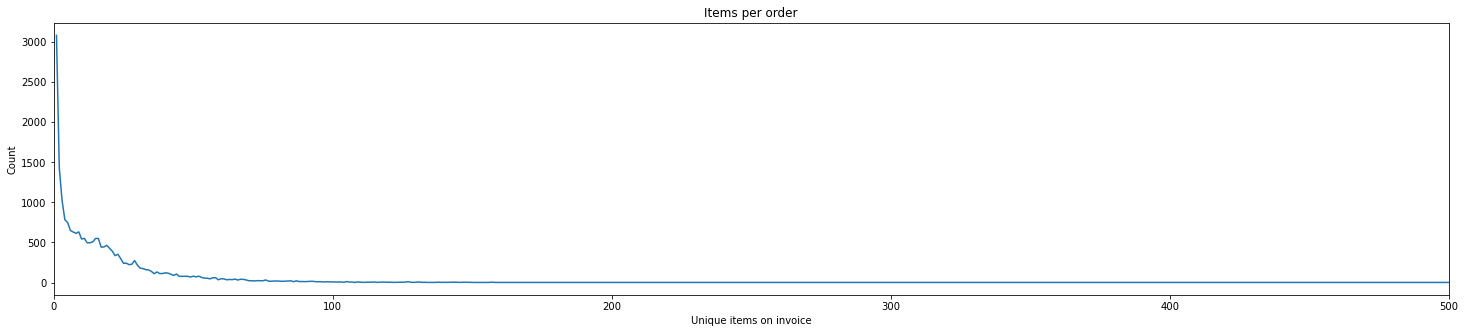

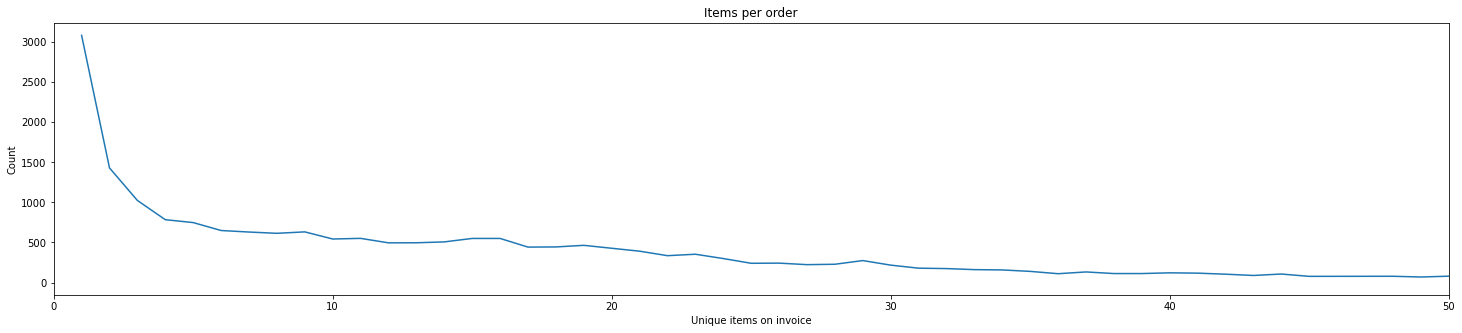

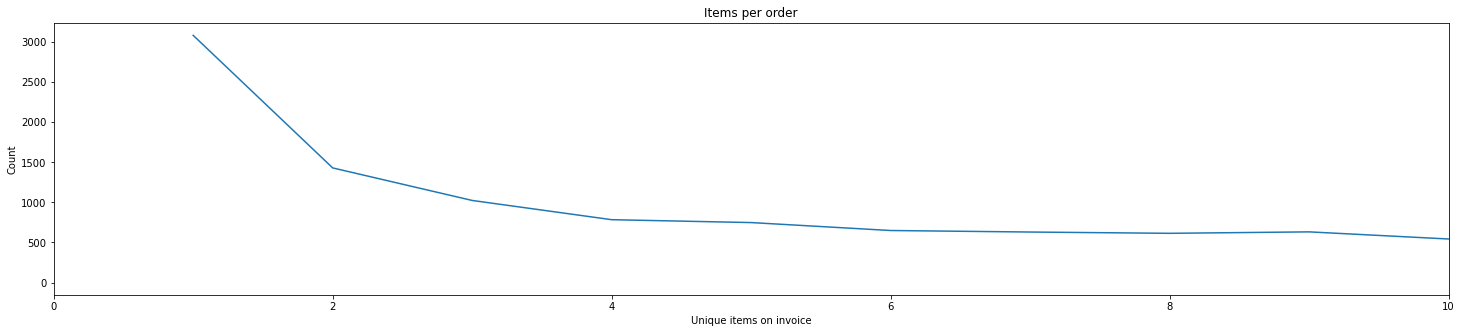

In [7]:
# Basic stats

grouped_by_invoiceno = df.groupby("InvoiceNo")

print("Items on invoice with most unique items:", df.groupby("InvoiceNo").size().max())
# axes = grouped_by_invoiceno.size().hist(bins=grouped_by_invoiceno.size().max()+1, figsize=(12, 4))
# axes = grouped_by_invoiceno.size().(bins=grouped_by_invoiceno.size().max()+1, figsize=(12, 4))
axes = df.groupby("InvoiceNo").size().value_counts().sort_index().plot.line(figsize=(25, 5), title="Items per order")
# display(axes.figure)
# axes = df.groupby("InvoiceNo").size().value_counts().sort_index()[0:100].plot.line(figsize=(25, 5))

# Interestingly, we have a few orders containing a great number of different products.
axes.set_xlabel('Unique items on invoice')
axes.set_ylabel('Count')
axes.set_xlim(0, 500)
display(axes.figure)
axes.set_xlim(0, 50)
display(axes.figure)
axes.set_xlim(0, 10)

# display(axes.figure)
# axes.set_xlim(0, 20)
# axes.set_ylim(0, 20)

print("")

Vi kan se ovenfor at langt det mest hyppige antal produkter per ordre er 1.
Til gengæld er der også en lang hale med ordrer med mange produkter.



Total number of orders: 21788
 - orders with 1 item: 3084
 - 14.2% of orders have only 1 item.
 - 25.4% of orders have 3 items or less.
 - 32.4% of orders have 5 items or less.
 - 46.5% of orders have 10 items or less.


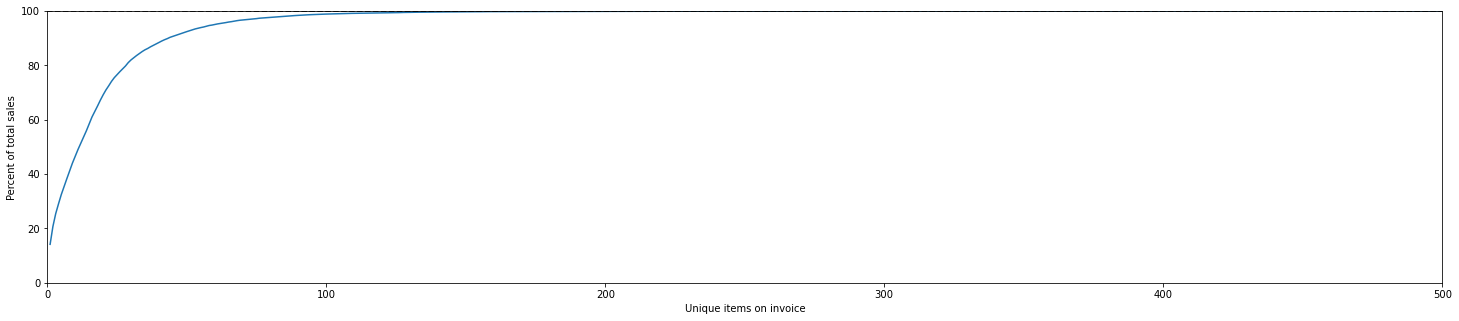

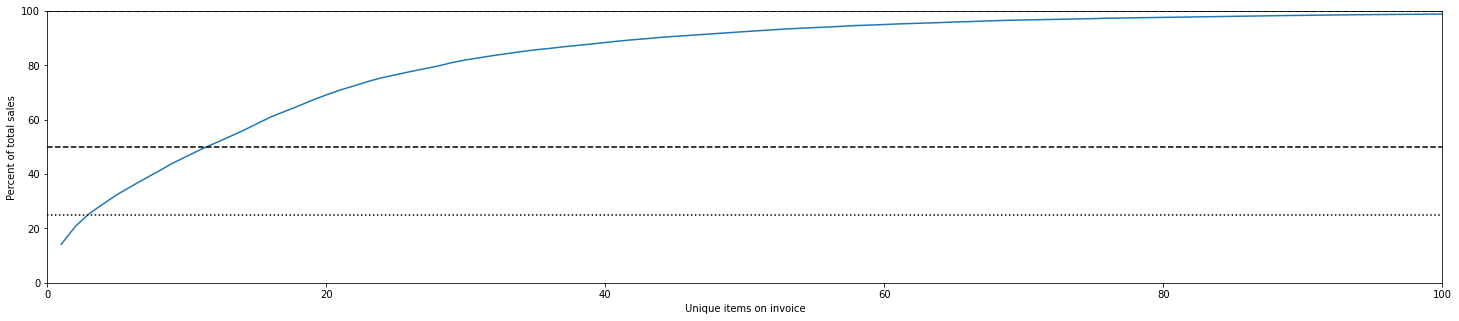

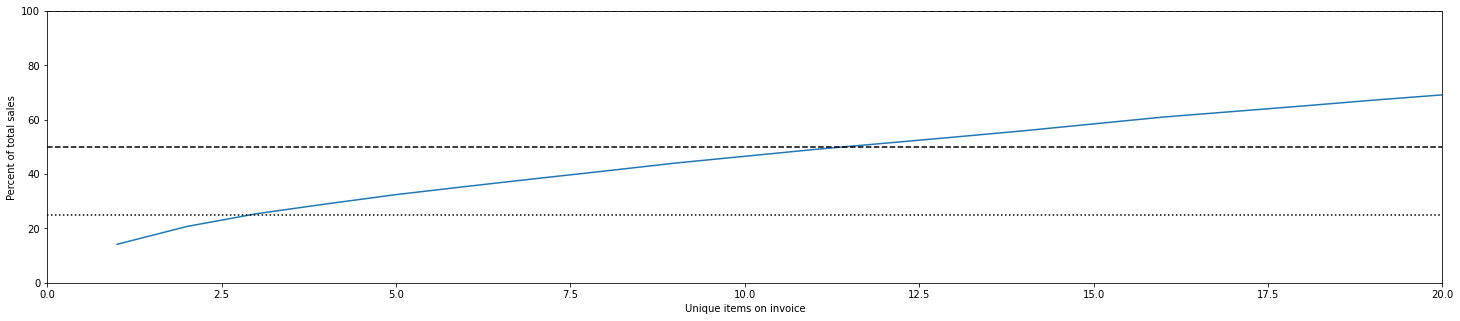

In [8]:
# axes = df.groupby("InvoiceNo").size().value_counts().sort_index()[0:20].plot.bar(figsize=(25, 5))
# order_sizes_cumsum = df.groupby("InvoiceNo").size().value_counts().sort_index().cumsum()
# Cumulative amount of the total:
order_sizes_cumsum = df.groupby("InvoiceNo").size().value_counts().sort_index().cumsum()
total_num_invoices = len(df.groupby("InvoiceNo"))  # Same as order_sizes_cumsum.max()
assert total_num_invoices == order_sizes_cumsum.max()
print(f"Total number of orders:", total_num_invoices)
print(f" - orders with 1 item:", order_sizes_cumsum[1])
print(f" - {100.*order_sizes_cumsum[1]/total_num_invoices:.1f}% of orders have only 1 item.")
print(f" - {100.*order_sizes_cumsum[3]/total_num_invoices:.1f}% of orders have 3 items or less.")
print(f" - {100.*order_sizes_cumsum[5]/total_num_invoices:.1f}% of orders have 5 items or less.")
print(f" - {100.*order_sizes_cumsum[10]/total_num_invoices:.1f}% of orders have 10 items or less.")


# CDF plots (Fraction in percent):
order_sizes_cdf = 100. * order_sizes_cumsum / order_sizes_cumsum.max()
axes = order_sizes_cdf.plot.line(figsize=(25, 5))
axes.axhline(100, linestyle="--", color="k")
axes.set_xlabel('Unique items on invoice')
axes.set_ylabel('Percent of total sales')
axes.set_xlim(0, 500)
axes.set_ylim(0, 100)
display(axes.figure)
axes.axhline([50], linestyle="--", color="k")
axes.axhline(25, linestyle=":", color="k")
axes.set_xlim(0, 100)
display(axes.figure)
axes.set_xlim(0, 20)
print("")


Den kummulative fordeling viser at 75% af alle bestillinger har over 3 unikke varer, og 50% af bestillinger har over 11 unikke varer. 14% af alle ordre har kun 1 vare.

Dvs:
* 25 % af bestillinger har 3 varer eller mindre.
* 14 % af bestillinger har kun 1 vare.

* ✅ Det er en relativt lille andel af det totale salg.

* ✅ Størstedelen af ordre har mange varer.


## Primitiv recommendation model baseret på produkt popularitet

Kan bruges til fx anonyme sessions hvor kunden ikke er logget på, og hvor kunden ikke har lagt noget i kurven endnu -> fx på forsiden.

Vi bruger salgstal (antal individuelle ordre af hvert produkt, uden at gange med quantity/antal per ordre) som mål for produkt popularitet.
* Alternativt kan også bruges "hvor mange unikke kunder har købt produkt X" for at undgå situationer hvor fx forbrugsvarer, fx støvsugeposer, som bliver købt flere gange af den samme kunde, "udkonkurerer" ikke-forbrugsvarer, fx en støvsuger.

Det er vigtigt at introducere noget tilfældighed, så det ikke altid bare er de samme top-5 produkter der bliver anbefalet.

Hvert produkt er ranket efter popularitet.
Salgstallet fungerer som vægt i en tilfældig fordeling.

Vi vælger produkt anbefalinger ved tilfældig valg af et produkt, hvor normaliseret salgstal fungerer som vægt for hvert produkt.


In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [10]:

# Først, lav en tabel med alle produkter.
products_df = df.groupby('StockCode').first()
del products_df['InvoiceNo']
del products_df['Quantity']
del products_df['CustomerID']
del products_df['Country']

# Beregn product order count:
# product_orders_count = df.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)
product_orders_count = df.groupby('StockCode')['InvoiceNo'].count()
products_df['OrdersCount'] = product_orders_count

# Beregn hvor mange brugere har købt hvert enkelt produkt:
products_df['UsersCount'] = product_users_count = df.groupby('StockCode')['CustomerID'].nunique()


# Sorter:
products_df_sorted = products_df.sort_values(by='OrdersCount', ascending=False)
# display(products_df_sorted)

print("Mest populære produkter (antal unikke ordre):")
with pd.option_context('display.max_rows', 100):
    display(products_df_sorted.head(100))


Mest populære produkter (antal unikke ordre):


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
85123A,WHITE HANGING HEART T-LIGHT HOLDER,12/1/2010 8:26,2.55,2077,858
22423,REGENCY CAKESTAND 3 TIER,12/1/2010 12:27,10.95,1905,887
85099B,JUMBO BAG RED RETROSPOT,12/1/2010 9:57,1.65,1662,636
84879,ASSORTED COLOUR BIRD ORNAMENT,12/1/2010 8:34,1.69,1418,679
47566,PARTY BUNTING,12/3/2010 12:43,4.65,1416,708
20725,LUNCH BAG RED RETROSPOT,12/1/2010 9:37,1.65,1359,532
22720,SET OF 3 CAKE TINS PANTRY DESIGN,12/13/2010 15:13,4.95,1232,640
20727,LUNCH BAG BLACK SKULL.,12/1/2010 11:29,1.65,1126,458
22197,SMALL POPCORN HOLDER,12/1/2010 10:19,0.72,1118,407


Histogram med antal ordre for de 100 mest populære produkter:


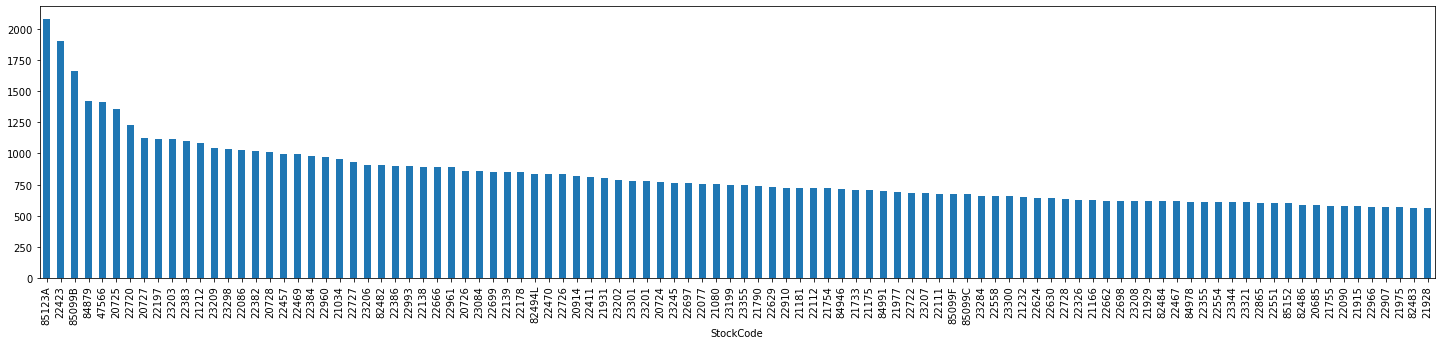

In [11]:
# Histogram:
print("Histogram med antal ordre for de 100 mest populære produkter:")
axsp = products_df_sorted['OrdersCount'][:100].plot.bar(figsize=(25, 5))
# axsp.figure

Fordeling af salg for alle 3676 produkter:


<AxesSubplot:xlabel='StockCode'>

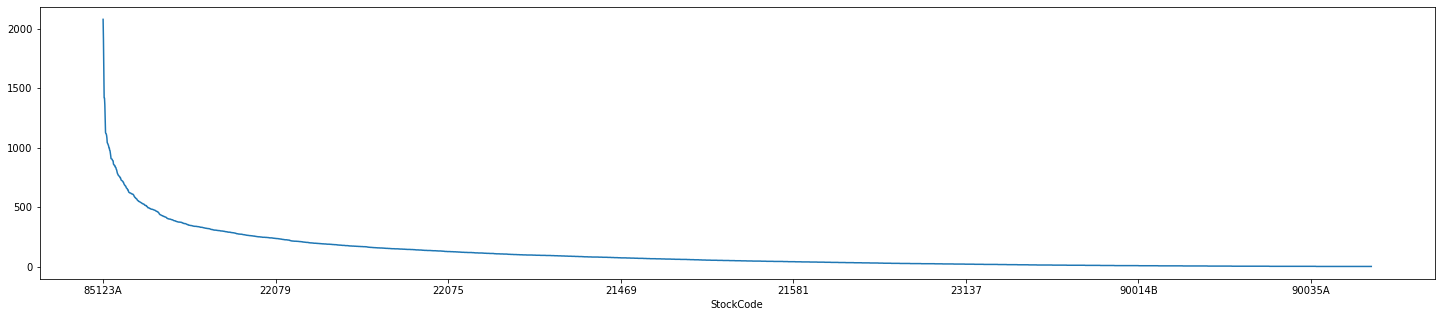

In [12]:
print(f"Fordeling af salg for alle {len(products_df_sorted)} produkter:")
products_df_sorted['OrdersCount'].plot.line(figsize=(25, 5))

In [13]:
import random

class SalesCountRecommendationModel():

    def __init__(self, sales_df, popularity_measure="UsersCount"):
        
        # Først, lav en tabel med alle produkter.
        # OBS: Doing it this way makes 'StockCode' the table index, not a column:
        products_df = sales_df.groupby('StockCode').first()
        del products_df['InvoiceNo']
        del products_df['Quantity']
        del products_df['CustomerID']
        del products_df['Country']
        # self.products_df = products_df

        # Beregn product order count:
        # product_orders_count = df.groupby('StockCode')['InvoiceNo'].count().sort_values(ascending=False)
        # products_df['OrdersCount'] = sales_df.groupby('StockCode')['InvoiceNo'].count()
        products_df['OrdersCount'] = sales_df.groupby('StockCode').size()  # same as count() on series
        products_df['UsersCount'] = sales_df.groupby('StockCode')['CustomerID'].nunique()
        # Sort and store:
        self.products_df_sorted = products_df.sort_values(by='OrdersCount', ascending=False)
        self.popularity_measure = popularity_measure
        # display(self.products_df_sorted)

    def recommend_stockcodes(self, basket=None, k=1, popularity_measure=None):
        """ This model doesn't use basket, only static sales numbers. """
        if popularity_measure is None:
            popularity_measure = self.popularity_measure
        # display(self.products_df_sorted.index)
        return random.choices(
            self.products_df_sorted.index, 
            weights=self.products_df_sorted[popularity_measure], 
            k=k
        )

    def recommend_product_rows(self, basket=None, k=1, popularity_measure=None):
        stockcodes = self.recommend_stockcodes(basket=basket, k=k, popularity_measure=popularity_measure)
        print(f"{stockcodes!r}", type(stockcodes))
        return self.products_df_sorted.loc[stockcodes]

sales_count_rm = SalesCountRecommendationModel(sales_df=df)

n_recommendations = 5
print(f"\nRecommend {n_recommendations} semi-random products based on sales/users count:\n")
product_rows = sales_count_rm.recommend_product_rows(k=n_recommendations)
product_rows



Recommend 5 semi-random products based on sales/users count:

['21217', '70006', '84279P', '22619', '23332'] <class 'list'>


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
21217,RED RETROSPOT ROUND CAKE TINS,12/2/2010 11:02,9.95,265,169
70006,LOVE HEART POCKET WARMER,12/2/2010 16:00,1.65,81,72
84279P,CHERRY BLOSSOM DECORATIVE FLASK,12/5/2010 11:57,3.75,105,79
22619,SET OF 6 SOLDIER SKITTLES,12/1/2010 10:29,3.75,348,250
23332,IVORY WICKER HEART LARGE,8/7/2011 15:43,1.65,282,207


Total orders (invoices): 21788
Dataset:
- 404909 rows,
- 21788 orders/invoices,
- 3676 unique StockCodes.
Computing sameorder graph dict-of-dict...

Time to compute same-order dict-of-dict, using for-loop on cartesian product of StockCodes in each order: 5.7 sec
 - single-threaded and inefficient for-loop.
 - number of nodes: 3667 (single-product orders do not contribute to same-order graph)


In [15]:
# Recommendation based on sameorder graph:

def recommend_sameorder_stockcodes(sameorder_dod, basket, k=1):
    if isinstance(basket, str):
        basket = [basket]
    item_weights = defaultdict(int)
    for item in basket:
        # self.sameorder_dod[item] = {stockcode: weight}
        if item not in sameorder_dod:
            print(f"NOTICE: Item stockcode {item} not present in SameOrder graph.")
            print(f"Perhaps the item has never been bought together with other items?")
        for stockcode, count in sameorder_dod[item].items():
            item_weights[stockcode] += count
    item_weights = dict(item_weights)
#     print("Combined recommender weights for basket items:", basket)
#     pprint(item_weights)
    codes, weights = zip(*item_weights.items())
    return random.choices(codes, weights=weights, k=k)


In [16]:
# Model class:
import numpy as np
import random

class SameOrderGraphRecommender:

    def __init__(self, sales_df):

        # Build same-order undirected graph:
        # dict[StockCode1][StockCode2] = count
        # grouped_by_invoiceno = df.groupby("InvoiceNo")
        # print("Total orders (invoices):", grouped_by_invoiceno.ngroups)
        print("Dataset:")
        print(f"- {len(sales_df)} rows,")
        print(f"- {sales_df.groupby('InvoiceNo').ngroups} orders/invoices,")
        print(f"- {len(sales_df['StockCode'].unique())} unique StockCodes.")

        print("Building SameOrder graph (dict-of-dict)... This should take about 5-10 seconds.")
        self.sameorder_dod = build_sameorder_product_dod_using_cartesian_forloop(sales_df)
        print(" - Done.")

    def recommend_stockcodes(self, basket, k=1):
        return recommend_sameorder_stockcodes(self.sameorder_dod, basket, k=k)

    def recommend_top_stockcodes(self, basket, k=1):
        if isinstance(basket, str):
            basket = [basket]
        item_weights = defaultdict(int)
        for item in basket:
            # self.sameorder_dod[item] = {stockcode: weight}
            if item not in sameorder_dod:
                print(f"NOTICE: Item stockcode {item} not present in SameOrder graph.")
                print(f"Perhaps the item has never been bought together with other items?")
            for stockcode, count in sameorder_dod[item].items():
                item_weights[stockcode] += count
        item_weights = dict(item_weights)
    #     print("Combined recommender weights for basket items:", basket)
    #     pprint(item_weights)
        codes, weights = zip(*item_weights.items())
        codes, weights = np.array(codes), np.array(weights)
        sidxs = np.argsort(weights)
        codes = codes[sidxs]
        return codes[:k]


sameorder_recommender = SameOrderGraphRecommender(df)



Dataset:
- 404909 rows,
- 21788 orders/invoices,
- 3676 unique StockCodes.
Building SameOrder graph (dict-of-dict)... This should take about 5-10 seconds.
 - Done.


In [17]:
# Eksempel: Brug SameOrderGraphRecommender til at anbefale 10 produkter for produkt '85123A'

print("Produkt '85123A':")
display(products_df.loc['85123A'])

# recommend_sameorder_stockcodes(sameorder_recommender.sameorder_dod, basket='85123A', k=10)
recommended_items = sameorder_recommender.recommend_stockcodes(basket='85123A', k=10)

print("Recommended items:", recommended_items)
display(products_df.loc[recommended_items])

Produkt '85123A':


Description    WHITE HANGING HEART T-LIGHT HOLDER
InvoiceDate                        12/1/2010 8:26
UnitPrice                                    2.55
OrdersCount                                  2077
UsersCount                                    858
Name: 85123A, dtype: object

Recommended items: ['21524', '22613', '22951', '22845', '22897', '23191', '84992', '23415', '23308', '21929']


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
21524,DOORMAT SPOTTY HOME SWEET HOME,12/1/2010 13:54,7.95,413,251
22613,PACK OF 20 SPACEBOY NAPKINS,12/7/2010 14:31,0.85,116,82
22951,60 CAKE CASES DOLLY GIRL DESIGN,12/1/2010 11:57,0.55,374,237
22845,VINTAGE CREAM CAT FOOD CONTAINER,12/3/2010 10:26,6.35,246,155
22897,OVEN MITT APPLES DESIGN,12/5/2010 12:29,1.45,179,135
23191,BUNDLE OF 3 RETRO NOTE BOOKS,5/10/2011 8:58,1.65,259,182
84992,72 SWEETHEART FAIRY CAKE CASES,12/1/2010 11:29,0.55,535,325
23415,HOME SWEET HOME HOOK,9/7/2011 15:52,1.65,46,42
23308,SET OF 60 VINTAGE LEAF CAKE CASES,6/5/2011 14:06,0.55,317,209


In [18]:
# Eksempel: Brug SameOrderGraphRecommender til at anbefale 10 produkter for produkt '21928'
basket = ['21928']

print("Basket:", basket)
display(products_df.loc[basket])

# recommend_sameorder_stockcodes(sameorder_recommender.sameorder_dod, basket='85123A', k=10)
recommended_items = sameorder_recommender.recommend_stockcodes(basket=basket, k=10)

print("Recommended items:", recommended_items)
display(products_df.loc[recommended_items])

Basket: ['21928']


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
21928,JUMBO BAG SCANDINAVIAN PAISLEY,12/1/2010 14:11,1.95,559,264


Recommended items: ['84462', '21670', '21755', '23177', '22150', '21907', '23286', '22287', '22386', '23202']


,Description,InvoiceDate,UnitPrice,OrdersCount,UsersCount
StockCode,,,,,
84462,3 PINK HEN+CHICKS IN BASKET,1/16/2011 16:23,1.25,6,6
21670,BLUE SPOT CERAMIC DRAWER KNOB,12/1/2010 14:41,1.25,303,159
21755,LOVE BUILDING BLOCK WORD,12/1/2010 8:34,5.95,582,337
23177,TREASURE ISLAND BOOK BOX,3/2/2011 12:10,2.25,225,174
22150,3 STRIPEY MICE FELTCRAFT,12/1/2010 10:29,1.95,417,288
21907,I'M ON HOLIDAY METAL SIGN,12/1/2010 11:21,2.10,334,208
23286,BLUE VINTAGE SPOT BEAKER,6/12/2011 13:12,0.85,167,126
22287,"DECORATION , WOBBLY CHICKEN, METAL",1/13/2011 13:36,1.65,60,51
22386,JUMBO BAG PINK POLKADOT,12/1/2010 9:37,1.95,903,372


In [19]:
# Visualize sameorder graph (network diagram; undirected, weighted):


## Pt. 2: Previous-orders recommendation model:

This model takes a time-directional customer-based approach:

Denne model bruger en tids-afhængig retningsbestemt tilgang:

* HVIS kunde A har købt produkt X, hvilke produkter købte kunden efterfølgende?
* Summér over alle kunder.
* Anbefal disse produkter til kunder som kigger på produkt X (eller har lagt produkt X i sin indkøbsvogn). 

OBS: Dette er stadig ikke en "personaliseret" recommendation model. Vi sammenligner ikke kunder mod hinanden, kun produkt-køb.


In [20]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom
